# Лабораторная работа: Предобработка и классификация текста (Jupyter Notebook)

Цели:
- Найти и подготовить датасет для классификации текстов (определение тональности — положительный/отрицательный).
- Провести предобработку текста: токенизация, лемматизация, удаление спецсимволов и стоп-слов.
- Преобразовать тексты в числовой вид с помощью TF-IDF (эмбеддинги не использовать).
- Обучить 3 модели (MultinomialNB, LogisticRegression, RandomForest), выбрать лучшую по метрикам.
- Спарсить новые тексты (пример: отзывы с IMDb), предобработать и классифицировать их.
- Построить облако слов (WordCloud) для выбранного набора текстов.

Примечание: ноутбук написан на Python. Выполните все ячейки по порядку.

In [1]:
# Установим необходимые пакеты (если не установлены).
%pip install -q nltk scikit-learn matplotlib seaborn wordcloud beautifulsoup4 lxml joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vladk\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings('ignore')

import re
from tqdm import tqdm
import nltk
from nltk.corpus import movie_reviews, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import requests
from bs4 import BeautifulSoup

import joblib

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('movie_reviews')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


True

## 1. Загрузка и обзор датасета

Будем использовать встроенный в NLTK корпус movie_reviews — набор размечённых отзывов о фильмах (положительные/отрицательные).

In [3]:
# Загрузим тексты и метки
fileids = movie_reviews.fileids()
texts = [movie_reviews.raw(fid) for fid in fileids]
labels = [movie_reviews.categories(fid)[0] for fid in fileids]  # 'pos' или 'neg'

print(f'Всего документов: {len(texts)}')
print('Примеры меток:', set(labels))
print('\nПервые 2 документа (обрезанный вывод):\n')
for i in range(2):
    print('--- Document', i, 'label =', labels[i])
    print(texts[i][:500].replace('\n', ' '), '\n')

Всего документов: 2000
Примеры меток: {'pos', 'neg'}

Первые 2 документа (обрезанный вывод):

--- Document 0 label = neg
plot : two teen couples go to a church party , drink and then drive .  they get into an accident .  one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares .  what's the deal ?  watch the movie and " sorta " find out . . .  critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package .  which is what makes this review an even harder one to write , since i generally applaud films which attempt 

--- Document 1 label = neg
the happy bastard's quick movie review  damn that y2k bug .  it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on .  little do they know the

## 2. Предобработка текста

Шаги:
- Приведение к нижнему регистру
- Удаление спецсимволов и цифр
- Токенизация
- Удаление стоп-слов
- Лемматизация (через WordNetLemmatizer с POS)

Опишем вспомогательные функции.

In [ ]:
# Ячейка: гарантируем доступность NLTK-ресурсов и даём устойчивую функцию preprocess_text
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords

# Попробуем скачать необходимые ресурсы (если их нет)
resources = {
    'punkt': 'tokenizers/punkt',
    'averaged_perceptron_tagger': 'taggers/averaged_perceptron_tagger',
    'wordnet': 'corpora/wordnet',
    'stopwords': 'corpora/stopwords'
}

for name, path in resources.items():
    try:
        nltk.data.find(path)
    except LookupError:
        try:
            print(f"Downloading NLTK resource: {name} ...")
            nltk.download(name)
        except Exception as e:
            print(f"Не удалось скачать {name}: {e}. Будет включён fallback режим для обработки без этого ресурса.")

# Подготовим элементы для предобработки
wn_lemmatizer = WordNetLemmatizer()
stop_words = set()
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    # если stopwords недоступен — используем минимальный набор
    stop_words = set(['the','and','for','with','that','this','was','but','not','you'])

tokenizer_re = RegexpTokenizer(r"[a-z']+")

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):#прил
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):#глаг
        return wordnet.VERB
    elif treebank_tag.startswith('N'):#сущ
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):#нареч
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text, do_lemmatize=True):
    text = text.lower()
    # оставляем буквы и апострофы (например, don't)
    text = re.sub(r"[^a-z'\s]", ' ', text)
    # сначала пробуем стандартный word_tokenize, если он доступен
    tokens = None
    try:
        from nltk import word_tokenize
        tokens = word_tokenize(text)
    except Exception:
        tokens = tokenizer_re.tokenize(text)
    # удаляем короткие токены и стоп-слова
    tokens = [t for t in tokens if len(t) > 2 and t not in stop_words]
    if do_lemmatize:
        # пробуем сделать POS-теггинг; если нет ресурса — лемматизируем без POS (меньше точно)
        try:
            pos_tags = pos_tag(tokens)
            tokens = [wn_lemmatizer.lemmatize(tok, get_wordnet_pos(pos)) for tok, pos in pos_tags]
        except Exception:
            # fallback: лемматизируем без указания POS (будет считать существительными)
            tokens = [wn_lemmatizer.lemmatize(tok) for tok in tokens]
    return ' '.join(tokens)

# Пример: проверьте на одном документе
# print(preprocess_text(texts[0])[:300])
print("Готово. Теперь снова выполните цикл Preprocessing.")

Готово. Теперь снова выполните цикл Preprocessing.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
processed_texts = []
for doc in tqdm(texts, desc='Preprocessing'):
    processed_texts.append(preprocess_text(doc))

print('\nПример обработанного текста:\n')
print(processed_texts[0][:500])

Preprocessing: 100%|██████████| 2000/2000 [00:13<00:00, 150.01it/s]


Пример обработанного текста:

plot two teen couple church party drink drive get accident one guy dy girlfriend continues see life nightmare what's deal watch movie sorta find critique mind fuck movie teen generation touch cool idea present bad package make review even harder one write since generally applaud film attempt break mold mess head lost highway memento good bad way making type film folk snag one correctly seem taken pretty neat concept executed terribly problem movie well main problem simply jumbled start normal do


## 3. Преобразование в числовой формат (TF-IDF)
Будем использовать TfidfVectorizer. Так как мы уже лемматизировали и удалили стоп-слова, достаточно простого векторизатора.

In [16]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)
X = tfidf.fit_transform(processed_texts)
y = [1 if lab == 'pos' else 0 for lab in labels]

print('TF-IDF matrix shape:', X.shape)

TF-IDF matrix shape: (2000, 42372)


## 4. Разделение на обучающую и тестовую выборки

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (1600, 42372) Test size: (400, 42372)


## 5. Обучение моделей
Обучим три модели: Multinomial Naive Bayes, Logistic Regression, Random Forest. Сравним метрики.

In [18]:
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='liblinear'),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}

results = {}
for name, model in models.items():
    print('Training', name)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results[name] = {'model': model, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    print(f"{name} -> accuracy: {acc:.4f}, precision: {prec:.4f}, recall: {rec:.4f}, f1: {f1:.4f}\n")

Training MultinomialNB
MultinomialNB -> accuracy: 0.8300, precision: 0.8056, recall: 0.8700, f1: 0.8365

Training LogisticRegression
LogisticRegression -> accuracy: 0.8425, precision: 0.8341, recall: 0.8550, f1: 0.8444

Training RandomForest
RandomForest -> accuracy: 0.8400, precision: 0.8505, recall: 0.8250, f1: 0.8376



In [19]:
# Показать сравнение метрик
import pandas as pd
metrics_df = pd.DataFrame({k: {m: v for m, v in res.items() if m != 'model'} for k, res in results.items()}).T
metrics_df

,accuracy,precision,recall,f1
MultinomialNB,0.8300,0.805556,0.870,0.836538
LogisticRegression,0.8425,0.834146,0.855,0.844444
RandomForest,0.8400,0.850515,0.825,0.837563


Выберем модель с наибольшим f1 (для баланса precision/recall).

In [20]:
best_name = max(results.keys(), key=lambda n: results[n]['f1'])
best_model = results[best_name]['model']
print('Лучшая модель:', best_name, 'с f1 =', results[best_name]['f1'])

Лучшая модель: LogisticRegression с f1 = 0.8444444444444444


Подробный отчёт для лучшей модели:

              precision    recall  f1-score   support

         neg       0.85      0.83      0.84       200
         pos       0.83      0.85      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



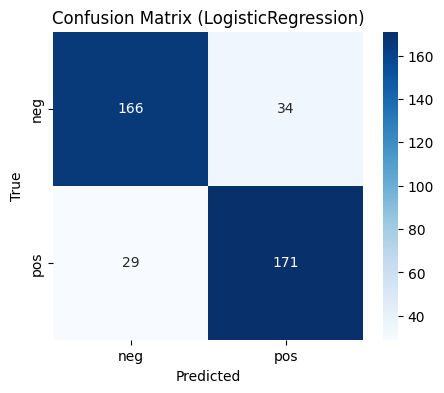

In [21]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['neg','pos']))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix ({best_name})')
plt.show()

## 6. Получение новых текстов (парсинг)
В примере спарсим отзывы с IMDb для конкретного фильма. Код написан универсально — URL можно менять. Учтите, что сайты могут менять структуру и блокировать парсинг. Если парсинг не удался, можно вручную добавить текстовые примеры.
Пример: парсинг страницы с отзывами фильма 'The Shawshank Redemption'.

In [28]:
import requests
from bs4 import BeautifulSoup

def fetch_imdb_reviews(movie_reviews_url, max_reviews=20):
    """Собирает текст отзывов с заданной страницы IMDb (reviews)."""
    headers = { 'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0' }
    try:
        r = requests.get(movie_reviews_url, headers=headers, timeout=15)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print('Ошибка при запросе:', e)
        return []

    soup = BeautifulSoup(r.text, 'lxml')
    
    # Новый основной селектор для текста отзыва
    # Текст находится внутри div.ipc-html-content-inner-div
    review_content_divs = soup.select('div[data-testid="review-overflow"] div.ipc-html-content-inner-div')
    
    reviews = []
    for div in review_content_divs:
        # Извлекаем текст, заменяя <br> на пробелы или новые строки для лучшей читаемости
        # Используем .get_text(separator=' ', strip=True) для очистки
        review_text = div.get_text(separator=' ', strip=True)
        reviews.append(review_text)

    if not reviews:
        print("Предупреждение: не удалось найти отзывы по основному селектору.")
        # Оставляем старый (менее вероятный) альтернативный селектор на всякий случай,
        # хотя он, вероятно, уже не актуален.
        old_review_divs = soup.find_all('div', class_='text show-more__control')
        reviews = [div.get_text(separator=' ', strip=True) for div in old_review_divs]
        
    return reviews[:max_reviews]

# Пример вызова (если работает):
# Не забудьте импортировать requests и BeautifulSoup
# import requests 
# from bs4 import BeautifulSoup 
imdb_url = 'https://www.imdb.com/title/tt0111161/reviews'  # The Shawshank Redemption
new_reviews = fetch_imdb_reviews(imdb_url, max_reviews=30)
print('Найдено отзывов:', len(new_reviews))
for i, r in enumerate(new_reviews[:3]):
    print('--- Review', i)
    print(r[:300], '...\n')

Найдено отзывов: 18
--- Review 0
It is no wonder that the film has such a high rating, it is quite literally breathtaking. What can I say that hasn't said before? Not much, it's the story, the acting, the premise, but most of all, this movie is about how it makes you feel. Sometimes you watch a film, and can't remember it days late ...

--- Review 1
I'm trying to save you money; this is the last film title that you should consider borrowing. Renting Shawshank will cost you five bucks... just plunk down the $25 and own the title. You'll wind up going back to this gem time and time again. This is one of few movies that are truly timeless. And it' ...

--- Review 2
This movie is not your ordinary Hollywood flick. It has a great and deep message. This movie has a foundation and just kept on being built on from their and that foundation is hope. Other than just the message of this movie the acting was phenomenal. Tim Robbins gave one of the greatest performances ...



Если сайт не отдал отзывы (пустой список) — можно заполнить new_reviews вручную или указать другой URL. Далее предобработаем и классифицируем полученные отзывы.

In [29]:
if len(new_reviews) == 0:
    # Пример запасных текстов (для демонстрации), если парсинг не сработал
    new_reviews = [
        "I absolutely loved this movie. The plot was touching and actors were amazing.",
        "Terrible movie. Waste of time, bad script and awful acting.",
        "It was okay, some parts were slow but overall enjoyable.",
    ]

processed_new = [preprocess_text(r) for r in new_reviews]
X_new = tfidf.transform(processed_new)
preds_new = best_model.predict(X_new)

for txt, p in zip(new_reviews, preds_new):
    label = 'pos' if p == 1 else 'neg'
    print('PREDICT:', label, ' — ', txt[:200].replace('\n',' '))

PREDICT: pos  —  It is no wonder that the film has such a high rating, it is quite literally breathtaking. What can I say that hasn't said before? Not much, it's the story, the acting, the premise, but most of all, th
PREDICT: pos  —  I'm trying to save you money; this is the last film title that you should consider borrowing. Renting Shawshank will cost you five bucks... just plunk down the $25 and own the title. You'll wind up go
PREDICT: pos  —  This movie is not your ordinary Hollywood flick. It has a great and deep message. This movie has a foundation and just kept on being built on from their and that foundation is hope. Other than just th
PREDICT: pos  —  I have never seen such an amazing film since I saw The Shawshank Redemption. Shawshank encompasses friendships, hardships, hopes, and dreams.  And what is so great about the movie is that it moves you
PREDICT: pos  —  Can Hollywood, usually creating things for entertainment purposes only, create art?  To create something of thi

## 7. Облако слов (Word Cloud)
Построим облако слов для всех положительных отзывов из тренировочной выборки (или для новых предсказанных как положительные).
Важно: перед построением удаляем стоп-слова.

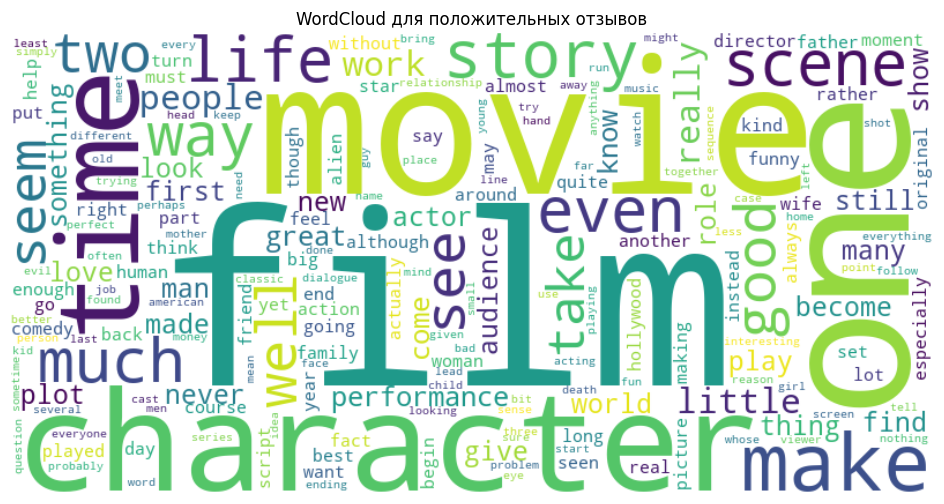

In [ ]:
# Собирать тексты, помеченные как положительные в тренировочной части
train_texts = [processed_texts[i] for i in range(len(processed_texts))]
train_labels = y

positive_texts = [t for t, lab in zip(train_texts, train_labels) if lab == 1]
pos_concat = ' '.join(positive_texts)

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(pos_concat)
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud для положительных отзывов')
plt.show()

1) Лемматизация  
- Лемматизация — это процесс приведения слова к его лемме (словарной форме). Например, running → run, cars → car, better → good (если лемматизатор учитывает форму).  
- Важная особенность — лемматизация учитывает часть речи (POS), поэтому даёт корректную «основу» слова в отличие от стемминга (stemming), который просто обрезает окончания и может давать несловарные корни: studying → studi.  
- Зачем нужна: уменьшает количество различных форм одного слова в корпусе, улучшает сопоставимость текстов и качество признаков в задачах классификации/поиска.

2) Метод Bag of Words (BoW)  
- Идея: представить текст как «мешок слов» — набор слов без учёта порядка. Для корпуса строится словарь (vocabulary), каждому документу сопоставляется вектор длины словаря, где компонент — количество появлений слова в документе (или бинарная индикация наличия).  
- Варианты: счётчики (term counts), бинарные векторы (0/1), частоты (counts нормированные на длину документа). Можно расширять через n-граммы (би- или триграммы), чтобы захватить некоторую локальную структуру.  
- Плюсы: простота, быстро и эффективно для классических моделей (NB, LR, SVM).  
- Минусы: теряется порядок слов и синтаксическая информация; признаки часто высокоразмерны и разрежены; не улавливает семантику слов.

3) Метод TF–IDF. Метрики TF и IDF  
- TF–IDF — способ взвешивания слов в документе, сочетающий локальную значимость в этом документе (TF) и общую редкость в корпусе (IDF). Вектор для документа получается умножением TF на IDF для каждого слова. Это снижает вес часто встречающихся слов (типа «the», «and») и повышает вес редких информативных слов.  

Формулы (классические варианты):
- TF(t,d) — term frequency: простейший вариант TF(t,d) = raw_count(t,d) (часто нормируют):
  - нормированный TF: TF(t,d) = count(t,d) / (общее число терминов в d)
  - или сублинейный: TF(t,d) = 1 + log(count(t,d)) при count>0
- IDF(t) — inverse document frequency:
  - классическая: IDF(t) = log( N / df(t) ), где N — число документов в корпусе, df(t) — число документов, содержащих термин t.
  - сглаженная/устойчивая: IDF(t) = log(1 + N / (1 + df(t))) или IDF(t) = log( N / (1 + df(t)) ) + 1
- TF–IDF(t,d) = TF(t,d) * IDF(t)

Пример (упрощённо):
- Корпус из N = 2 документов: D1 = «cat dog dog», D2 = «dog mouse».  
  - Для термина dog: count в D1 = 2, df(dog)=2 → IDF(dog)=log(2/2)=0 → TF–IDF для dog будет ≈0 (т.е. слово малоинформативно, т.к. везде).  
  - Для cat: df(cat)=1 → IDF(cat)=log(2/1)=0.693 → TF–IDF(cat,D1)=1 * 0.693 = 0.693.

Практические заметки:
- Часто после вычисления TF–IDF векторы нормируют (L2-норма) перед обучением моделей, чтобы учесть разную длину документов.  
- Параметры в реализации (например, в sklearn): min_df/max_df (удаление слишком редких/слишком частых слов), ngram_range, use_idf, smooth_idf, sublinear_tf.  
- TF–IDF хорошо работает для классической текстовой классификации и информационного поиска; но не захватывает глубокую семантику слов — для этого используют эмбеддинги/нейросети (в следующих этапах курса).

Если нужно, могу:  
- привести небольшой числовой пример расчёта TF–IDF в виде кода (Python/sklearn) и показать результаты на 2–3 документах;  
- или коротко показать отличия лемматизации и стемминга на примерах. Что предпочитаете?

1) Общая цель
- Задача: решить задачу классификации текстов (в ноутбуке — бинарная классификация тональности отзывов: pos / neg).
- Подход: классический NLP-пайплайн — сбор данных → предобработка → преобразование в числовой формат (TF–IDF) → обучение моделей → выбор лучшей → применение на новых данных → визуализация (облако слов).

Теперь по шагам.

2) Датасет (movie_reviews из NLTK)
- Что это: готовый корпус с текстами отзывов о фильмах, размеченных как "pos" или "neg".
- Почему удобно: небольшой, сбалансированный, сразу размечен — идеально для обучения и демонстрации.
- Как используется: texts = movie_reviews.raw(fileid) даст сырой текст; labels = movie_reviews.categories(fileid) — метки.

3) Предобработка текста (функция preprocess_text)
Задача предобработки — снизить размер словаря, убрать «шум», привести разные формы слова к общей форме.

Что делается в вашем коде (пошагово) и зачем:
- Приведение к нижнему регистру: "The" и "the" считаются одинаковым токеном.
- Удаление не-алфавитных символов: удаляются цифры, пунктуация, лишние символы, чтобы токены были чистыми словами. В варианте с допустимыми апострофами сохраняются формы типа don't.
- Токенизация: разбивка текста на токены (слова). В ноутбуке использовался word_tokenize; в fallback — RegexpTokenizer (регекс-основная токенизация). Проблема: word_tokenize требует ресурса punkt, который иногда отсутствует — отсюда LookupError.
- Удаление коротких слов и стоп-слов: короткие токены (len<=2) и часто встречающиеся «неинформативные» слова (stopwords: the, and ...) убираются, чтобы уменьшить шум.
- POS-теггинг + лемматизация: pos_tag для получения части речи, затем WordNetLemmatizer.lemmatize(token, pos). Зачем POS? Чтобы лемматизация знала: is "running" глагол или существительное; без POS лемматизатор часто делает хуже. Лемматизация — приведение слова к базовой форме (run, not runn).
- Fallbackы: если отсутствует averaged_perceptron_tagger (еще один LookupError в вашем случае), реализован вариант: при недоступности теггера лемматизируем без POS (менее точно) или просто используем RegexpTokenizer.

Подводные камни и советы:
- POS-теггер и punkt требуют загрузки NLTK-ресурсов (nltk.download('punkt'), nltk.download('averaged_perceptron_tagger'), nltk.download('wordnet'), nltk.download('stopwords')). Без интернета — используйте fallback.
- Лемматизация корректнее стемминга, но медленнее и требует POS для лучшего результата.
- Удаление стоп-слов лучше делать после лемматизации? Обычно делают до или после — смысл один: убрать частотные неинформативные слова.

4) Bag of Words и TF–IDF (преобразование текста в числа)
- Bag of Words (BoW): модель, в которой документ представляется вектором длины словаря. Компоненты:
  - raw counts: count(t, d)
  - бинарная: 1 если слово есть, 0 иначе
  - частоты: count(t,d) / len(d)
  BoW теряет порядок слов, но хорошо работает в классификации.

- TF–IDF: улучшение BoW, взвешивает слова по частоте в документе и редкости в корпусе.
  - TF (term frequency): обычно TF(t,d) = count(t,d) или нормированная версия TF = count(t,d) / (total terms in d). Есть sublinear вариант TF = 1 + log(count) при count>0.
  - IDF (inverse document frequency): IDF(t) = log( N / df(t) ), где N — число документов, df(t) — число документов, где t встречается. Сглаженные варианты добавляют 1 в знаменатель/числитель, либо добавляют +1 к результату.
  - TF–IDF(t,d) = TF(t,d) * IDF(t)
  Идея: повышение веса слов, которые часто в данном документе, но редки по корпусу → более информативные признаки.

Как это реализовано в коде:
- TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)
  - ngram_range=(1,2) — учитываются униграммы и биграммы (помогает фиксировать пары слов).
  - min_df=3 — слова, встречающиеся в <3 документах, исключаются (уменьшение шумных редких признаков).
  - max_df=0.9 — слова, встречающиеся более чем в 90% документов, исключаются (очень частые слова).
- Результат — разреженная матрица X (количество документов × размер словаря).

Практические замечания:
- Нормировка: sklearn по умолчанию нормирует строки (L2) в TfidfVectorizer при use_idf=True, что делает длину документов менее значимой.
- min_df и max_df помогают бороться с шумом и сокращать размер признакового пространства.

5) Разделение данных (train_test_split)
- train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
  - stratify=y гарантирует, что доля классов в обучающей и тестовой выборках равна исходной (полезно для баланса).
  - random_state — фиксирует случайность для воспроизводимости.

6) Обучение моделей
В ноутбуке обучены три модели: MultinomialNB, LogisticRegression, RandomForestClassifier.

- Multinomial Naive Bayes (MultinomialNB)
  - Предположение: признаки (термы) независимы (наивное предположение), и частоты слов в документе подчиняются мультино­мному распределению.
  - Почему подходит для текстов: слова считаются многократно появляющимися событиями; модель проста, быстра и часто даёт хорошие результаты на BoW или TF–IDF.
  - Ограничения: независимость признаков — упрощение; плохо моделирует коррелирующие признаки.

- Logistic Regression
  - Это линейная модель, оценивающая вероятность принадлежности к классу через сигмоид (для бинарной) или softmax (многоклассовая).
  - Регуляризация (L1/L2) помогает избегать переобучения; в sklearn по умолчанию L2.
  - Часто показывает очень хорошее качество на TF–IDF (линейно разделимые признаки).

- Random Forest
  - Ансамбль деревьев решений: множество деревьев, каждое обучено на бутстрэп-выборке и с случайной подвыборкой признаков, итог — голосование.
  - Плюсы: умеет моделировать нелинейные зависимости, устойчив к выбросам, не требует сильной предобработки.
  - Минусы: больший размер модели, более медленен при большом числе признаков, менее интерпретируем.

В коде:
- Обучение: model.fit(X_train, y_train)
- Предсказание: model.predict(X_test)
- Сравнение по метрикам: accuracy, precision, recall, f1

7) Метрики оценки (и как их интерпретировать)
- Accuracy = (TP + TN) / (TP + TN + FP + FN)
  - Доля правильно классифицированных.
  - Хороша при сбалансированных классах; вводит заблуждение при сильном дисбалансе.

- Precision = TP / (TP + FP)
  - Доля истинно положительных среди предсказанных положительных.
  - Важна, когда цена ложноположительного высока (например, спам-фильтр: пометить важный email как спам — плохо).

- Recall (Sensitivity) = TP / (TP + FN)
  - Доля правильно найденных позитивных среди всех реальных позитивных.
  - Важна, когда важно не пропустить позитивные случаи (например, диагностика болезни).

- F1 = 2 * (Precision * Recall) / (Precision + Recall)
  - Гармоническое среднее precision и recall — компромисс, если важны оба.

- Confusion Matrix:
  - 2×2 матрица для бинарной классификации:
    - [[TN, FP],
       [FN, TP]]
  - По ней легко видеть, какие ошибки чаще: больше FP или FN.

Как выбирать модель:
- Выбираете по целевой метрике (F1, precision, recall или accuracy) в зависимости от задачи.
- Можно использовать cross_val_score или GridSearchCV для более стабильной оценки/тюнинга.

8) Классификация новых данных (парсинг)
- Парсинг: requests.get(url) + BeautifulSoup для извлечения текста отзывов.
- Ограничения:
  - Структура HTML сайтов может меняться — селекторы могут перестать работать.
  - Сайты могут блокировать парсинг (rate-limiting, bot-detection).
  - Всегда уважайте robots.txt и правила сайта.
- После получения текстов надо применить ту же предобработку (preprocess_text), затем tfidf.transform(processed_new) → модель.predict(X_new).
- Крайне важно использовать тот же tfidf (тот же словарь, те же настройки), что и при обучении, иначе признаки не будут соответствовать.

9) Word Cloud (облако слов)
- Что делает: визуализирует частоту слов — чем чаще слово, тем больше его размер в облаке.
- Важно: перед построением нужно удалить стоп-слова и нежелательные токены.
- Полезно для быстрого визуального анализа тем/ключевых слов в корпусе.
- Можно ограничивать облако по частоте, или строить по предсказанным положительным/отрицательным отзывам отдельно для сравнения.

10) Сохранение модели
- joblib.dump(best_model, 'best_text_classifier.joblib') и joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
- При дальнейшем использовании:
  - tfidf = joblib.load('tfidf_vectorizer.joblib'); model = joblib.load('best_text_classifier.joblib')
  - processed = preprocess_text(new_text); X_new = tfidf.transform([processed]); pred = model.predict(X_new)
- Причина: модель и векторизатор нужно хранить вместе, так как модель ожидает вход в том же пространстве признаков.

11) Ошибки и их решение (на основе ваших LookupError)
- Проблемы: LookupError для 'punkt' и 'averaged_perceptron_tagger' означает, что NLTK-ресурсы не загружены в текущую среду.
- Решения:
  - Если есть интернет в среде: выполнить nltk.download('punkt'), nltk.download('averaged_perceptron_tagger'), nltk.download('wordnet'), nltk.download('stopwords').
  - Если нет интернета: использовать fallback — RegexpTokenizer (регулярная токенизация) и лемматизацию без POS (или без лемматизации вообще). Это снижает качество, но позволяет работать офлайн.
- В ноутбуке предложены оба варианта и реализован устойчивый preprocess_text с fallback.

12) Дополнительные улучшения и рекомендации
- Pipeline: собрать preprocessing + tfidf + model в sklearn.Pipeline, тогда ты можешь удобно делать GridSearchCV и сохранять единый pipeline.
- GridSearchCV/RandomizedSearchCV: подбирать гиперпараметры (C в LogisticRegression, alpha в NB, n_estimators и max_depth в RandomForest, параметры TF-IDF: ngram_range, min_df, max_df, use_idf, sublinear_tf).
- Баланс классов: если классы небалансированы — использовать class_weight='balanced' (в LogisticRegression/RandomForest) или методы ресэмплинга (SMOTE, downsampling).
- Доп. признаки: char n-grams (полезны для ошибок/стилистики), POS-теги как признаки, TF–IDF на биграммах и униграммах, биграммы часто улучшают качество.
- Использование эмбеддингов/нейросетей: word2vec, GloVe, BERT — дают лучший результат, но сложнее и выходят за рамки этой лабораторной.
- Оценка стабильности: кросс-валидация (k-fold) даст более устойчивую оценку производительности, чем один train/test разбиение.
- Интерпретация: для логистической регрессии можно смотреть веса признаков; для RandomForest — feature_importances_. Для NaiveBayes — условные вероятности слов.

13) Конкретные практические подсказки при повторном запуске ноутбука
- Сначала выполните ячейки с установкой зависимостей и скачиванием NLTK-ресурсов (если есть сеть). Пример:
  - !pip install -q nltk scikit-learn wordcloud beautifulsoup4 lxml
  - import nltk; nltk.download('punkt'); nltk.download('averaged_perceptron_tagger'); nltk.download('wordnet'); nltk.download('stopwords')
- Если ловите LookupError — вставьте в ноутбук реализацию preprocess_text с fallback (RegexpTokenizer и лемматизация без POS).
- Для отладки парсинга IMDb: сначала откройте страницу в браузере, посмотрите структуру HTML, отладьте селектор в BeautifulSoup (используйте soup.prettify() и manual search).

14) Как интерпретировать результаты (пример)
- Если у лучшей модели F1 ≈ 0.85, precision 0.87, recall 0.83:
  - Модель в целом хороша, немного чаще пропускает положительные примеры (recall < precision).
  - Посмотрите confusion matrix, чтобы увидеть реальные числа FP и FN.
- Если Naive Bayes дал лучший F1 — это нормальная ситуация для текстов; NB очень эффективен на частотных признаках.

1) Почему нужна предобработка текста — общая идея
- Текст — это нечисловые данные: модели машинного обучения работают с числами. Предобработка переводит «сырые» строки в набор числовых признаков, удаляет шум и уменьшает размер и разреженность признакового пространства.
- Цели:
  - убрать мусор (HTML, спецсимволы, лишние пробелы);
  - привести разные формы слов к единому виду (run, runs, running → run);
  - уменьшить разреженность и «шум» (убрать стоп-слова, редкие токены);
  - получить стабильные и воспроизводимые признаки (тот же словарь для train и для новых текстов).

2) Последовательность этапов предобработки (типичный пайплайн)
Ниже — обычный порядок операций, с пояснениями.

- Очистка (cleaning)
  - удаление HTML-тегов (strip HTML), URL, email, цифр, лишних пробелов;
  - зачем: спецсимволы и ссылки обычно не несут смысла для тональности/темы и мешают токенизации.
  - пример: re.sub(r'<[^>]+>', ' ', text).

- Нормализация регистра
  - переводим всё в нижний регистр (text.lower()).
  - зачем: "The" и "the" — одно и то же слово.

- Токенизация
  - разбивка строки на лексемы (слова) — word_tokenize, RegexpTokenizer и т.д.
  - нюансы: английская токенизация учитывает сокращения и пунктуацию; для других языков нужны специфичные токенизаторы.

- Удаление пунктуации и нежелательных символов
  - можно делать до или после токенизации; иногда полезно сохранять апострофы (don't).

- Удаление стоп-слов
  - стоп-слова — частые служебные слова (the, and, is...), которые обычно не информативны для темы/тональности.
  - осторожно: в некоторых задачах стоп-слова несут смысл (например, "not" важен для тональности!). Поэтому кастомный список стоп-слов — хорошая идея.

- Нормализация форм слов: стемминг или лемматизация
  - Стемминг (Porter, Snowball): грубое обрезание окончаний → быстро, но может получить несловарные корни (studying → studi).
  - Лемматизация (WordNetLemmatizer и т.п.): приводит слово к словарной форме с учётом POS (running→run, better→good). Точнее, но медленнее и требует POS-тегов.
  - зачем: снижает число уникальных токенов, улучшает обобщение.

- POS-теггинг (опционально)
  - разметка частей речи (noun, verb, adj) — полезно, если вы создаёте дополнительные признаки (например, частота прилагательных для тональности) или используете лемматизацию с POS.

- Формирование n-грамм (опционально)
  - uni-, bi-, tri-grams. Биграммы позволяют учесть локальные сочетания слов ("not good"), что очень важно для тональности.
  - минус: увеличивают размер словаря и разреженность.

- Фильтрация по частоте (min_df, max_df)
  - удаляем слишком редкие токены (могут быть опечатками) и слишком частые (встречаются почти во всех документах — малоинформативны).
  - Это сокращает размер признакового пространства и шум.

- При необходимости — нормализация/скейлинг признаков
  - для некоторых моделей (например, логистической регрессии) полезно L2-нормирование TF–IDF вектора. Sklearn TfidfVectorizer делает это по умолчанию.
  - для CountVectorizer иногда применяют нормировку вручную.

Результат предобработки: для каждого документа — «чистая» последовательность токенов или собранный вектор признаков (после векторизации).

3) Преобразование в числовую форму (BoW, TF, TF–IDF)
- Bag-of-Words (BoW, CountVectorizer)
  - словарь = все токены (или n-граммы) из корпуса (ограниченный min_df/max_df).
  - документ → вектор длинны |vocab|, компонент i = count(word_i in doc) (или 0/1).
  - вектор разреженный (sparse matrix).

- TF–IDF
  - TF (term frequency): локальная частота слова в документе (raw count, freq, или sublinear: 1+log(count)).
  - IDF (inverse document frequency): log(N / df(t)) (иногда сглаженная), отражает «редкость» в корпусе.
  - TF–IDF = TF * IDF — высокие значения для слов, часто встречающихся в документе, но редких в целом по корпусу.
  - Преимущество: выделяет информативные термины, снижает вес очень частых слов.

4) Как модель «видит» текст после векторизации
- После TF/TF–IDF у нас есть числовая матрица X (n_documents × n_features). Каждая строка — вектор признаков документа.
- Эти векторы обычно:
  - разреженные (много нулей);
  - высокоразмерные (тысячи — сотни тысяч признаков);
  - несбалансированные по масштабу (по длине документа) — поэтому часто нормируют.

5) Как разные модели учатся на этих признаках (интуиция и математика)
Ниже — базовые подходы и как они используют признаки.

- Multinomial Naive Bayes (MNB)
  - Модель предполагает, что слова в документе (их счётчики) независимы при условии класса (наивное предположение).
  - Для каждого класса C оценивается P(C) (приор) и условные вероятности P(word_i | C) ≈ (count(word_i, docs_in_C) + α) / (total_words_in_C + α * V), где α — сглаживание (Laplace), V — размер словаря.
  - Для документа d модель вычисляет P(C | d) ∝ P(C) * ∏_i P(word_i | C)^{count_i(d)} (или в лог-пространстве суммирует count_i * log P(word_i|C)).
  - Почему часто хороша для текстов:
    - естественная модель для счётчиков слов (мультино-мальная),
    - быстро обучается,
    - работает хорошо при большом количестве признаков и малом числе примеров.
  - Минусы:
    - независимость признаков — упрощение (не учитывает биграммы, корреляции), но в задачах тональности часто работает отлично.

- Логистическая регрессия (Logistic Regression)
  - Линейная модель: предсказывает вероятность класса как σ(w·x + b), где w — веса признаков, x — вектор TF–IDF.
  - Обучение — максимизация вероятности (или минимизация log-loss) с регуляризацией (L2 по умолчанию):
    - задача: min_w [ − Σ y log p + λ ||w||^2 ].
  - Интерпретация:
    - каждый признак (слово) получает вес w_i: положительный вес → увеличивает вероятность положительного класса; отрицательный — наоборот.
    - больший абсолютный вес → более важный признак.
  - Регуляризация (λ, или C в sklearn) предотвращает переобучение, отдавая предпочтение более «гладким» (меньше по модулю) весам.
  - Работает очень хорошо с TF–IDF; легко интерпретируется (коэффициенты), быстро обучается в высоких размерностях.

- Random Forest (ансамбль деревьев)
  - Набор деревьев решений, обученных на бутстрэп-выборках и с рандомизацией признаков.
  - Дерево строит последовательные пороги по признакам (например, tfidf[word_i] > 0.3), чтобы разделить классы.
  - RandomForest агрегирует (голосует) предсказания деревьев.
  - Преимущества:
    - моделирует нелинейные зависимости и взаимодействия признаков,
    - не требует нормировки признаков,
    - устойчив к шуму.
  - Недостатки:
    - плохо масштабируется при очень высоком числе (сотни тысяч) разреженных признаков — деревья пытаются разрезать по очень редким признакам, модели становятся громоздкими и медленными.
    - менее интерпретируем по сравнению с линейными моделями (хотя есть feature_importances_).

6) Выбор наилучшей модели — процесс и критерии
- Что значит «лучшая»: зависит от метрики, релевантной задаче (precision, recall, F1, accuracy, ROC-AUC и т.д.). Важно заранее определить цель:
  - минимизировать ложноположительные (FP) — оптимизируем precision,
  - минимизировать ложноотрицательные (FN) — оптимизируем recall,
  - баланс — F1.
- Оценка моделей:
  - train/test split — базовая оценка; stratify=y поддерживает пропорции классов.
  - k-fold cross-validation — более стабильная оценка среднего качества; уменьшает зависимость от конкретного разбиения.
  - GridSearchCV / RandomizedSearchCV — подбор гиперпараметров (регуляризация C, α в NB, n_estimators и max_depth в RF, параметры TF–IDF: ngram_range, min_df, sublinear_tf).
- Метрики:
  - Confusion matrix (TN, FP, FN, TP) — основа для precision/recall.
  - ROC-AUC — для задач с градиентацией вероятностей, полезно при несбалансированных классах.
  - Precision-Recall curve — более информативна при сильном дисбалансе.
- Стратегии выбора:
  - выбирайте модель с наилучшей метрикой на валидации (k-fold), затем проверьте на отложенном тесте;
  - оцените стабильность (std по фолдам), если разброс большой — выбор ненадёжен;
  - используйте простые модели как baseline (Naive Bayes), затем пробуйте сложнее;
  - учитывайте практические требования: скорость предсказания, память, интерпретируемость.

7) Технические и практические моменты, влияющие на обучение
- Разреженность и высокая размерность
  - TF–IDF/BoW даёт разреженные матрицы; многие модели (логрег, NB, линейные SVM) хорошо работают с sparse матрицами.
  - RandomForest и другие деревья плохо масштабируются при очень высокой размерности.

- Нормализация признаков
  - для логистической регрессии и SVM полезно нормировать строки (L2) — TfidfVectorizer делает это.
  - для NB нормализация TF иногда ухудшает интерпретацию, поэтому raw counts или sublinear_tf иногда лучше.

- Регуляризация и отбор признаков
  - L1-регуляризация (Lasso) в логистической регрессии приводит к разреженным весам (отбор признаков).
  - Можно использовать селекцию признаков (SelectKBest, chi2) перед моделью, если много шума.

- Классовый дисбаланс
  - Используйте class_weight='balanced' или ресэмплинг (oversample minority, undersample majority, SMOTE).
  - Метрики: accuracy бесполезна при сильном дисбалансе; предпочитайте precision/recall/F1/PR-AUC.

- Переобучение vs недообучение
  - Переобучение: модель слишком сложная (слишком большой RF, недостаточная регуляризация).
  - Недообучение: слишком простая модель или недостаточно признаков.
  - Диагностика: сравнить качество на train и test; если train >> test — переобучение.

- Стабильность предобработки
  - Всё, что делается на train (тот же словарь, та же нормализация), должно делаться на новых данных. Поэтому сохраняйте tfidf/vectorizer и применяйте их к новым текстам, а не пересоздавайте словарь заново.

8) Как модель делает предсказание на конкретном документе — подробная интуиция
- Шаги:
  1. Текст → preprocess_text → токены (очищенные, лемматизированные).
  2. Токены → tfidf.transform → вектор x (разреженный).
  3. Модель использует x:
     - Naive Bayes: суммирует log-вероятности слов для каждого класса и выбирает класс с наибольшей суммой.
     - Logistic Regression: вычисляет s = w·x + b; p = sigmoid(s); если p > threshold (обычно 0.5) → класс 1, иначе 0. Для многокласса — softmax.
     - Random Forest: каждое дерево делает своё предсказание (на основе порогов/разделений по признакам); итог — большинство голосов или усреднение вероятностей.
  4. Дополнительно: можно получить вероятности (predict_proba) и настроить порог в зависимости от требуемой trade-off между precision и recall.

- Пример интуитивный:
  - Документ содержит слова «excellent», «performance», «boring».
  - TF–IDF для «excellent» и «performance» имеют высокие значения и большие положительные веса в логрег → повышают вероятность положительного класса; «boring» имеет отрицательный вес → уменьшает. Сумма определяет итог.

9) Интерпретация модели (как понять, почему она решила так)
- Линейные модели: по весам w_i можно увидеть наиболее важные слова для каждого класса.
  - Список top positive и top negative признаков — простая интерпретация.
- Naive Bayes: по условным вероятностям P(word|class) видно, какие слова ассоциируются с классами.
- Random Forest: feature_importances_ показывает вклад признаков, но интерпретация сложнее.
- Локальные объяснения: LIME или SHAP показывают, какие признаки повлияли на конкретное предсказание.

10) Практические рекомендации и checklist для запуска пайплайна
- Всегда сохраняйте vectorizer (vocab) и модель вместе.
- Используйте sklearn.Pipeline([('preproc', custom_preproc), ('tfidf', TfidfVectorizer(...)), ('clf', LogisticRegression(...))]) — удобство, воспроизводимость, совместимость с GridSearchCV.
- Начните с простых моделей (MNB, LR) как baseline.
- Применяйте кросс-валидацию при подборе гиперпараметров.
- Следите за leakage: не используйте информацию из теста при формировании словаря (fit только на train).
- Для тональности обязательно оставьте отрицательные маркеры типа "not" в стоп-словах (не удаляйте их).
- Если разделение train/test stratify, фиксируйте random_state.
- Если парсите чужие сайты — соблюдайте robots.txt и не перегружайте сервер запросами.

11) Небольшой псевдокод пайплайна (чтобы связать всё вместе)
- В словах, не код, но понятие:

1) сбор данных
2) split = train_test_split(data, stratify=labels)
3) pipeline = Pipeline([
     ('preproc', FunctionTransformer(preprocess_text_for_sklearn)),
     ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
     ('clf', LogisticRegression(C=1.0))
   ])
4) grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
5) grid_search.fit(X_train_raw, y_train)
6) best = grid_search.best_estimator_
7) preds = best.predict(X_test_raw)
8) оценка: classification_report(y_test, preds), confusion_matrix

12) Частые ошибки и как их избегать
- Применять fit_transform на train и transform на test (не fit на всём корпусе — leakage).
- Удалять слишком много слов (чтобы не потерять смысл) или оставлять все (шум).
- Игнорировать биграммы для тональности ("not good" vs "good").
- Не нормализовать TF–IDF перед линейными моделями (обычно нормировать нужно).
- Ожидать, что сложная модель всегда лучше — часто простая линейная регрессия/Naive Bayes выигрывают на текстах.

13) Что влияет сильнее всего на качество в текстовой классификации
- Качество предобработки (сохранили важные отрицания, нормализовали орфографию?).
- Выбор признаков (uni/bi-grams, min_df/max_df).
- Баланс между bias/variance (регуляризация).
- Количество и разнообразие тренировочных данных.
- Сходимость гиперпараметров (C, α) и корректность оценки (CV).
